## Test case

In [1]:
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import pymc as pm
import arviz as az
from pymc.gp.util import plot_gp_dist

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-white")

RANDOM_SEED = 2023-10-10
rng = np.random.default_rng(RANDOM_SEED)

N_DRAWS = 1000
N_TUNE = 1000
N_PPC = 200 # No. prior predictive samples
N_NEW = 200 # No. posterior predictive samples

Running on PyMC v5.6.1


In [2]:
def plot_lc(filepath):
    """Plot light curve from raw CSV data including 1 sigma error bars"""
    
    this_lc = pd.read_csv(filepath)
    this_x = this_lc['mjd']
    this_y = this_lc['f_peak']
    this_yerr = this_lc['f_peak_err']
    mean_y = np.nanmean(this_y)

    plt.figure(figsize=(12, 5))
    plt.plot(this_x, this_y, "_b", ms=8, alpha=1, label="Observed data")
    plt.axhline(y=mean_y, c='blue', ls=':')
    plt.errorbar(x=this_x, y=this_y, yerr=this_yerr,
                 fmt="none", ecolor="k", elinewidth=1, capsize=3,
                 label=r"1 $\sigma$")
    plt.title(f"{filepath.stem} (N={len(this_y)})")
    plt.xlabel("Time")
    plt.ylabel("Flux")
    plt.legend()

In [3]:
csv_paths_list = list(Path('data_raw').iterdir())
csv_paths_list

[PosixPath('data_raw/80_ra271.352_dec-29.642_MAXIJ1803TraPDB_andersson.csv'),
 PosixPath('data_raw/1817_ra284.905_dec-8.658_J1858TraPDB_andersson.csv'),
 PosixPath('data_raw/428_ra236.530_dec-46.922_4U1543TraPDB_andersson.csv'),
 PosixPath('data_raw/502_ra236.310_dec-47.644_4U1543TraPDB_andersson.csv')]

# 428_ra236.530_dec-46.922_4U1543

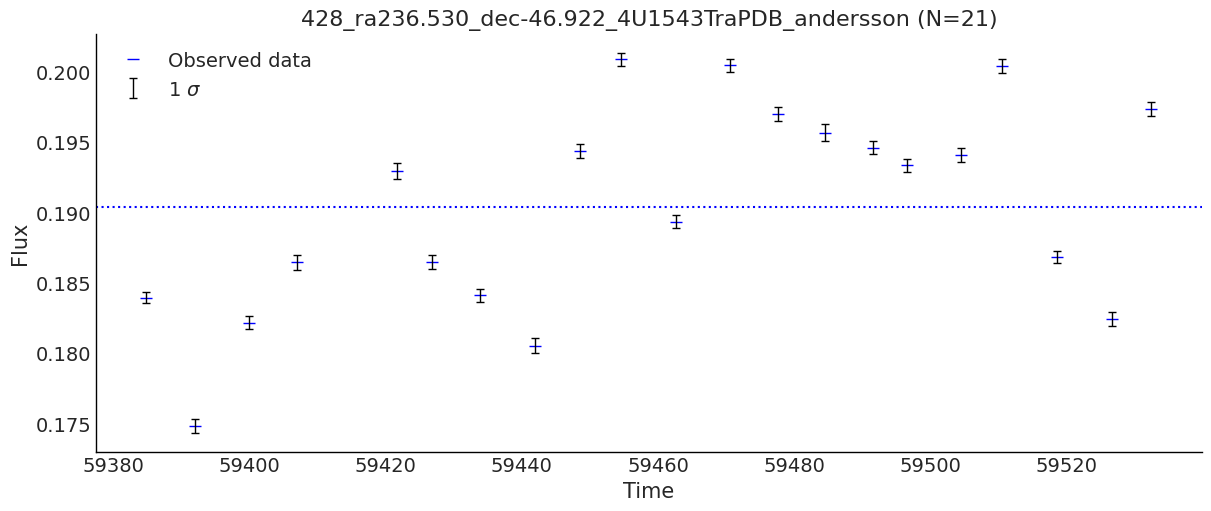

In [4]:
fpath = csv_paths_list[2]
plot_lc(fpath)

In [5]:
lc = pd.read_csv(fpath)

y = lc["f_peak"].to_numpy()
y_stderr = lc["f_peak_err"].to_numpy()
t = lc["mjd"].to_numpy()

N = t.shape[0]
y_min = np.nanmin(y)
y_max = np.nanmax(y)
y_mean = np.nanmean(y)
y_sd = np.nanstd(y)
y_range = np.ptp(y)
y_stderr_mean = np.nanmean(y_stderr)
y_stderr_sd = np.nanstd(y_stderr)
t_min = np.nanmin(t)
t_max = np.nanmax(t)
t_range = np.ptp(t)
t_mingap = np.diff(t).min()
t_maxgap = np.diff(t).max()

t = t - t_min # translate minimum to origin

{"N":N, "y_min":y_min, "y_max":y_max, "y_mean":y_mean, "y_sd":y_sd, "y_range":y_range, "y_stderr_mean":y_stderr_mean, "y_stderr_sd":y_stderr_sd, 
"t_min":t_min, "t_max":t_max, "t_range":t_range, "t_minGap":t_mingap, "t_maxGap":t_maxgap}

{'N': 21,
 'y_min': 0.174837825023698,
 'y_max': 0.200900812679486,
 'y_mean': 0.1903982656340805,
 'y_sd': 0.007211076120712034,
 'y_range': 0.026062987655788017,
 'y_stderr_mean': 0.0004906526416835524,
 'y_stderr_sd': 4.041657284245993e-05,
 't_min': 59384.88435070358,
 't_max': 59532.45253232262,
 't_range': 147.56818161904084,
 't_minGap': 4.999907674260612,
 't_maxGap': 14.682972612783487}

## SE Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{SE}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN},i} \sim \textrm{HalfNormal}(e_i^2)$$

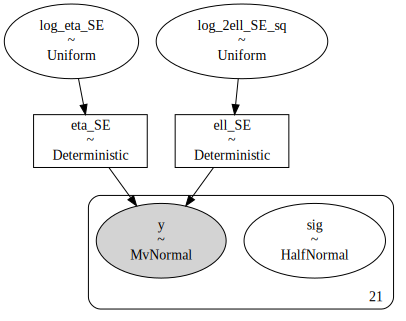

In [6]:
with pm.Model() as se_gp_model:
    log_2ell_SE_sq = pm.Uniform("log_2ell_SE_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_SE = pm.Deterministic("ell_SE", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_SE_sq))

    log_eta_SE= pm.Uniform("log_eta_SE", lower=-15, upper=5)
    eta_SE = pm.Deterministic("eta_SE", pm.math.exp(log_eta_SE))

    cov_func = eta_SE**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_SE)
    
    gp = pm.gp.Marginal(cov_func=cov_func) # zero mean function 

    sig = pm.HalfNormal("sig", sigma=y_stderr) 
    cov_noise = pm.gp.cov.WhiteNoise(sigma=y_stderr)

    y_ = gp.marginal_likelihood(
        "y", 
        X=t.reshape(-1,1), 
        y=y.reshape(-1,1).flatten(), 
        sigma=cov_noise
    ) 

pm.model_to_graphviz(se_gp_model)

Sampling: [log_2ell_SE_sq, log_eta_SE, sig, y]


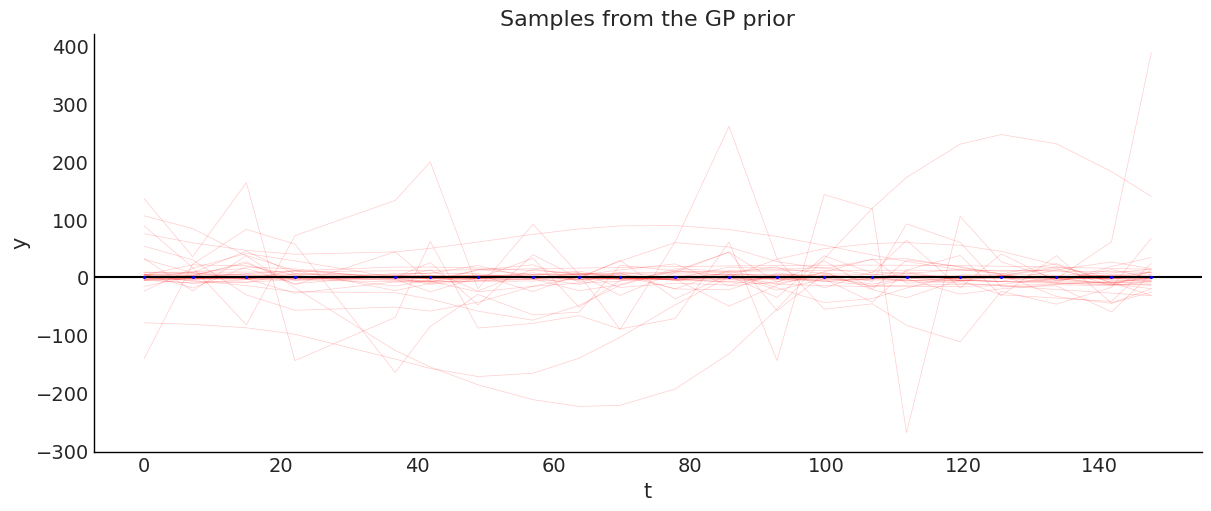

In [7]:
with se_gp_model:
    se_gp_trace = pm.sample_prior_predictive(samples=N_PPC, random_seed=rng)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in se_gp_trace.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=0.5, alpha=0.2, color="red")

ax.scatter(x=t, y=y, s=1.5, c="blue", zorder=10)
ax.axhline(0, color="black")
ax.set_title("Samples from the GP prior")
ax.set_ylabel("y")
ax.set_xlabel("t");

In [8]:
with se_gp_model:
    se_gp_trace.extend(
        pm.sample(
            draws=N_DRAWS, 
            tune=N_TUNE, 
            chains=4,
            cores=4, 
            random_seed=rng
        )       
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_eta_SE, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


In [9]:
variable_names = ["log_2ell_SE_sq", "log_eta_SE", "ell_SE", "eta_SE"]
az.summary(se_gp_trace, stat_focus="median", fmt="wide", var_names=variable_names, round_to="none", kind="all")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
log_2ell_SE_sq,5.706069,0.070757,5.483057,5.896594,0.001971,3435.024402,2857.820642,1.002410
log_eta_SE,-1.989372,0.130472,-2.313356,-1.559805,0.003507,3695.837619,2384.348100,1.002178


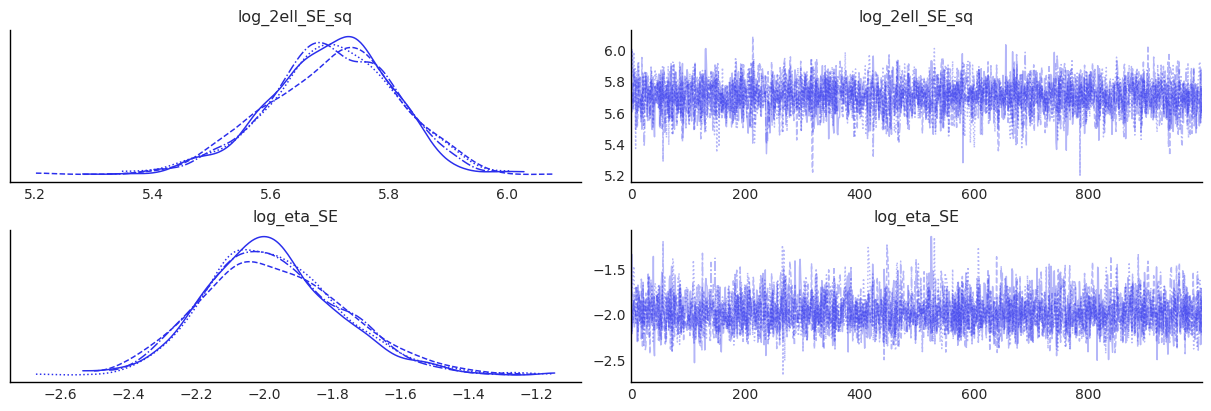

In [10]:
az.plot_trace(se_gp_trace, var_names=variable_names, combined=False);

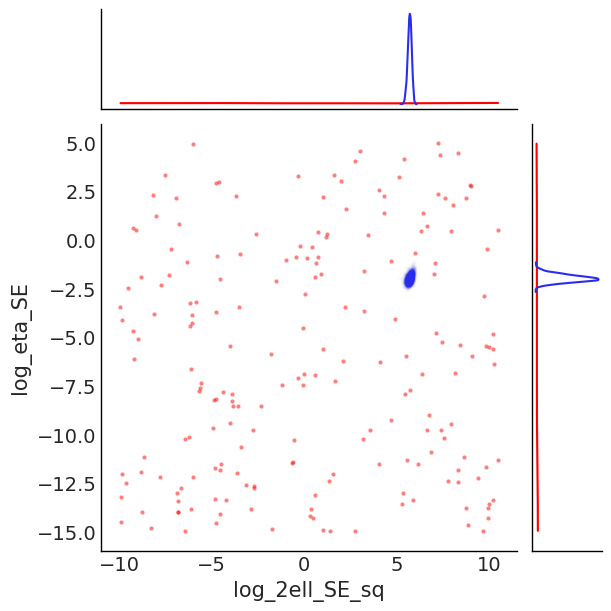

In [11]:
ax_list = az.plot_pair(
    se_gp_trace, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(6,6), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    se_gp_trace, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

In [12]:
t_new = np.linspace(
    start=np.floor(t.min()), 
    stop=np.ceil(t.max()), 
    num = N_NEW
).reshape(-1,1)

with se_gp_model:
    f_star = gp.conditional(name="f_star", Xnew=t_new, jitter=1e-6, pred_noise=False) 

In [13]:
with se_gp_model:
    se_gp_trace.extend(
        pm.sample_posterior_predictive(
            se_gp_trace.posterior,  
            var_names=["f_star"], 
            random_seed=rng
        )
    )

Sampling: [f_star]


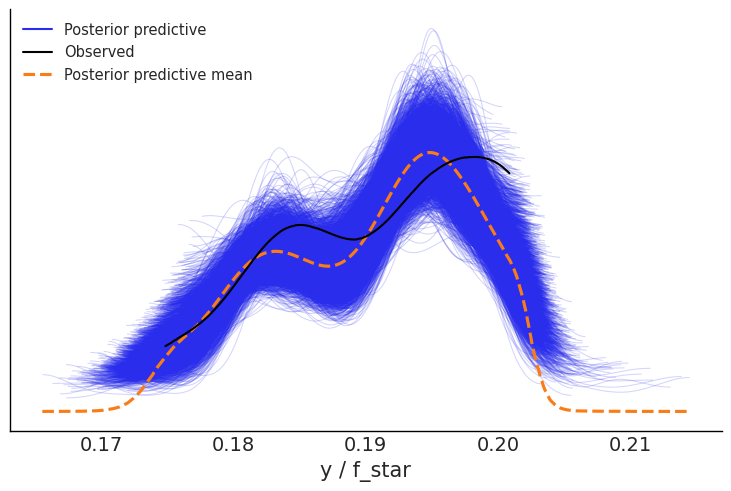

In [14]:
az.plot_ppc(se_gp_trace, data_pairs={"y":"f_star"});

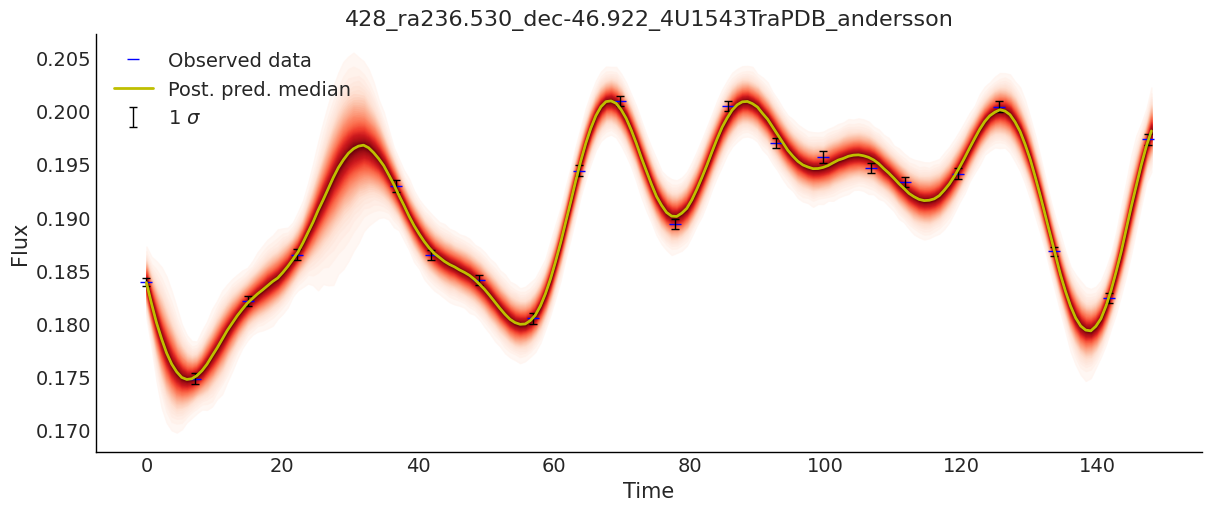

In [15]:
y_postpred = az.extract(se_gp_trace.posterior_predictive, var_names=["f_star"])
y_postpred_median = y_postpred.median(dim="sample")

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(t, y, "_b", ms=8, alpha=1, label="Observed data")
plt.errorbar(x=t, y=y, yerr=y_stderr, fmt="none", ecolor="k", elinewidth=1, capsize=3, label=r"1 $\sigma$")
plot_gp_dist(
    ax=ax, 
    samples=y_postpred.transpose("sample", ...),
    x=t_new,
    plot_samples=False
)
plt.plot(t_new.flatten(), y_postpred_median, "y", linewidth=2, label="Post. pred. median")
plt.title(f"{fpath.stem}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend();

## Matern $\frac{3}{2}$ Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{M}(\tau))$$

$$k_\textrm{M}(\tau) =  \eta_\textrm{M}^2\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

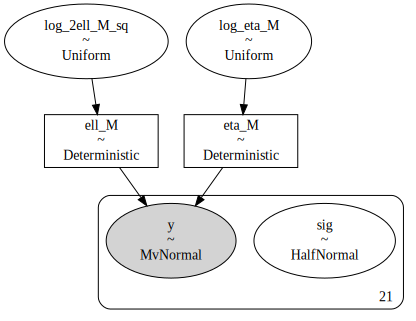

In [16]:
with pm.Model() as m32_gp_model:
    log_2ell_M_sq = pm.Uniform("log_2ell_M_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_M = pm.Deterministic("ell_M", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_M_sq))

    log_eta_M= pm.Uniform("log_eta_M", lower=-15, upper=5)
    eta_M = pm.Deterministic("eta_M", pm.math.exp(log_eta_M))

    cov_func = eta_M**2 * pm.gp.cov.Matern32(input_dim=1, ls=ell_M)
    
    gp = pm.gp.Marginal(cov_func=cov_func) # zero mean function 

    sig = pm.HalfNormal("sig", sigma=y_stderr) 
    cov_noise = pm.gp.cov.WhiteNoise(sigma=y_stderr)

    y_ = gp.marginal_likelihood(
        "y", 
        X=t.reshape(-1,1), 
        y=y.reshape(-1,1).flatten(), 
        sigma=cov_noise
    ) 

pm.model_to_graphviz(m32_gp_model)

Sampling: [log_2ell_M_sq, log_eta_M, sig, y]


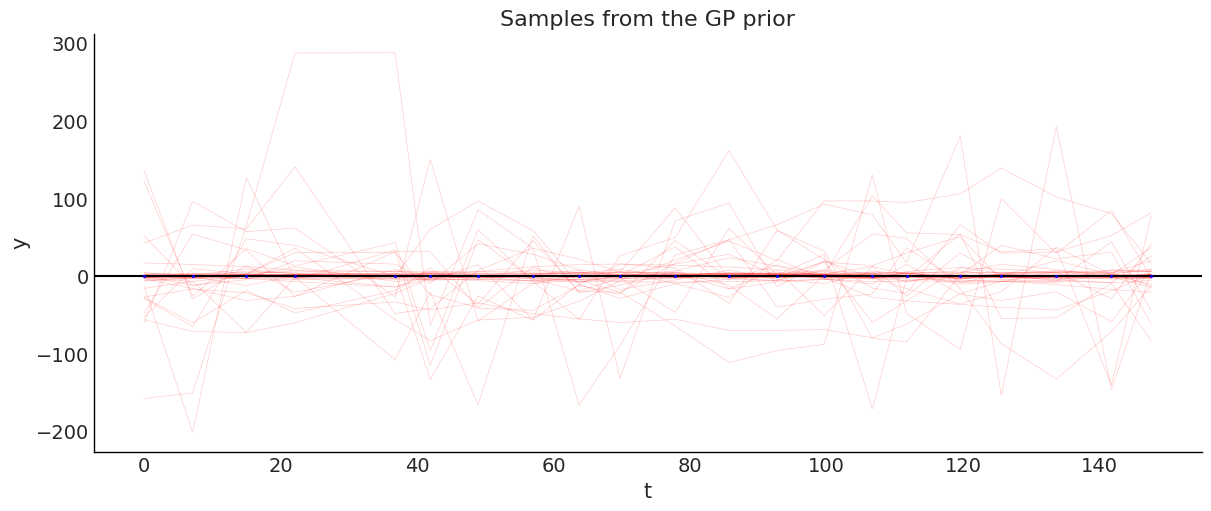

In [17]:
with m32_gp_model:
    m32_gp_trace = pm.sample_prior_predictive(samples=N_PPC, random_seed=rng)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in m32_gp_trace.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=0.5, alpha=0.2, color="red")

ax.scatter(x=t, y=y, s=1.5, c="blue", zorder=10)
ax.axhline(0, color="black")
ax.set_title("Samples from the GP prior")
ax.set_ylabel("y")
ax.set_xlabel("t");

In [18]:
with m32_gp_model:
    m32_gp_trace.extend(
        pm.sample(
            draws=N_DRAWS, 
            tune=N_TUNE, 
            chains=4,
            cores=4, 
            random_seed=rng
        )       
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_M_sq, log_eta_M, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


In [19]:
variable_names = ["log_2ell_M_sq", "log_eta_M", "ell_M", "eta_M"]
az.summary(m32_gp_trace, stat_focus="median", fmt="wide", var_names=variable_names, round_to="none", kind="all")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
log_2ell_M_sq,9.833182,0.370721,8.848289,10.617252,0.014078,2550.679246,1021.630258,1.003224
log_eta_M,-1.712483,0.243083,-2.326430,-1.072472,0.011144,2207.795201,1663.363218,1.002422
ell_M,96.545788,17.548717,59.001984,142.886734,0.679986,2550.679246,1021.630258,1.003224
eta_M,0.180417,0.042961,0.097644,0.342162,0.002011,2207.795201,1663.363218,1.002422


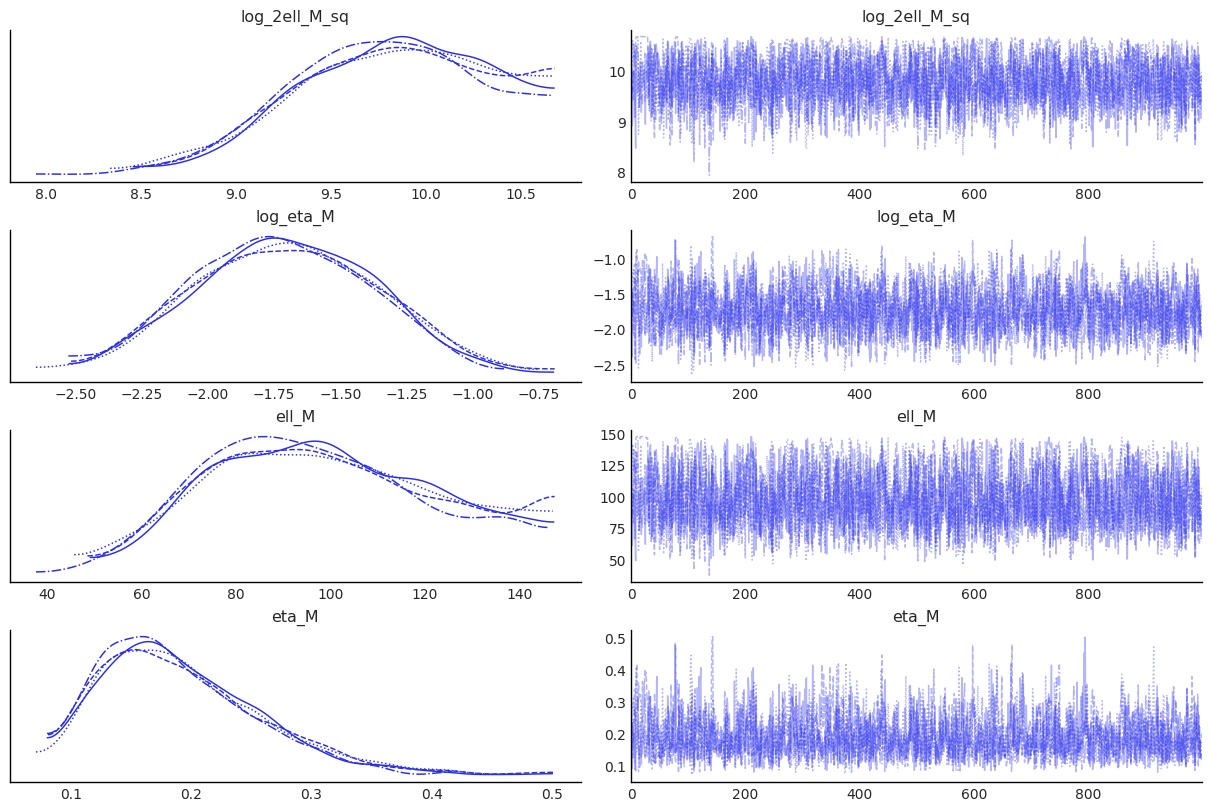

In [20]:
az.plot_trace(m32_gp_trace, var_names=variable_names, combined=False);

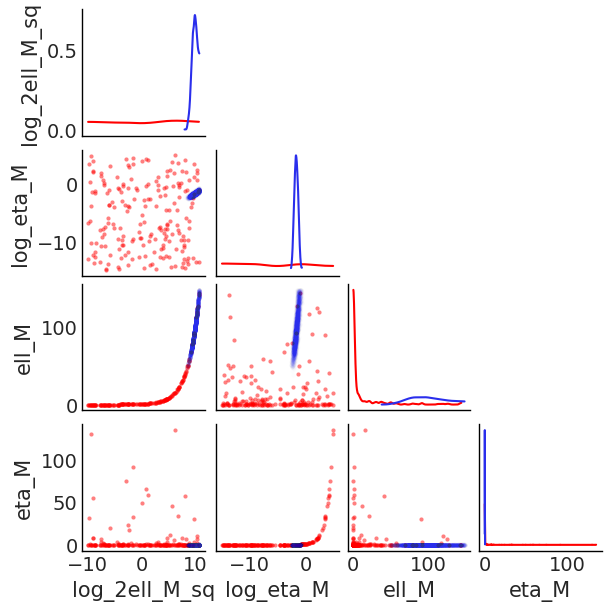

In [21]:
ax_list = az.plot_pair(
    m32_gp_trace, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(6,6), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    m32_gp_trace, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

In [22]:
t_new = np.linspace(
    start=np.floor(t.min()), 
    stop=np.ceil(t.max()), 
    num = N_NEW
).reshape(-1,1)

with m32_gp_model:
    f_star = gp.conditional(name="f_star", Xnew=t_new, jitter=1e-6, pred_noise=False) 

In [23]:
with m32_gp_model:
    m32_gp_trace.extend(
        pm.sample_posterior_predictive(
            m32_gp_trace.posterior,  
            var_names=["f_star"], 
            random_seed=rng
        )
    )

Sampling: [f_star]


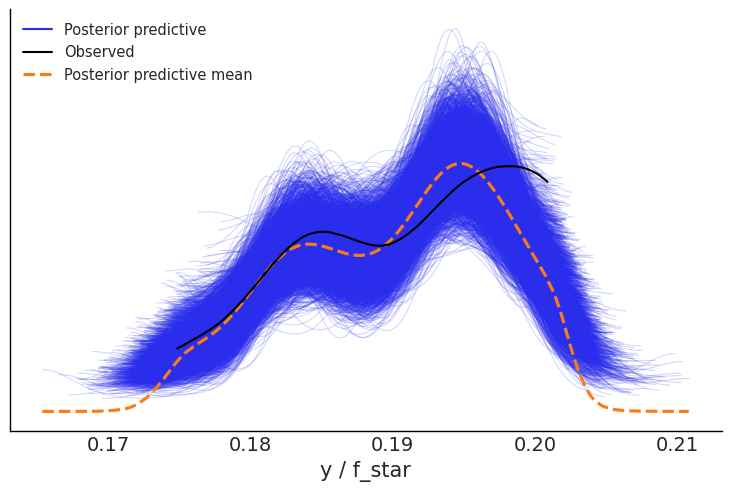

In [24]:
az.plot_ppc(m32_gp_trace, data_pairs={"y":"f_star"});

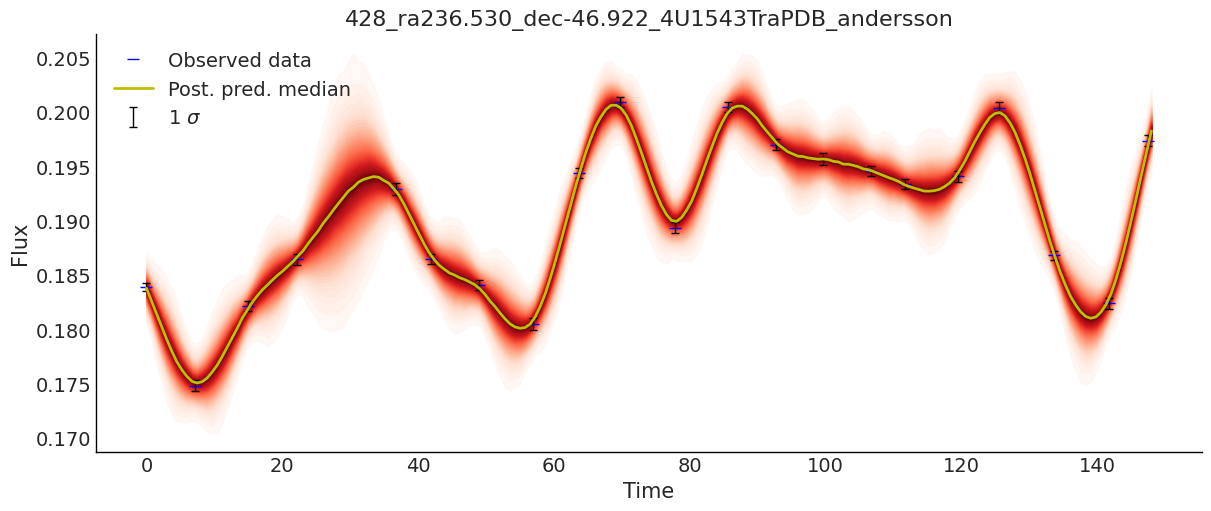

In [25]:
y_postpred = az.extract(m32_gp_trace.posterior_predictive, var_names=["f_star"])
y_postpred_median = y_postpred.median(dim="sample")

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(t, y, "_b", ms=8, alpha=1, label="Observed data")
plt.errorbar(x=t, y=y, yerr=y_stderr, fmt="none", ecolor="k", elinewidth=1, capsize=3, label=r"1 $\sigma$")
plot_gp_dist(
    ax=ax, 
    samples=y_postpred.transpose("sample", ...),
    x=t_new,
    plot_samples=False
)
plt.plot(t_new.flatten(), y_postpred_median, "y", linewidth=2, label="Post. pred. median")
plt.title(f"{fpath.stem}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend();

## SE + Matern $\frac{3}{2}$ Kernels

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{SE+M}(\tau))$$

$$k_\textrm{SE+M}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\} + \eta^2_\textrm{M}\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

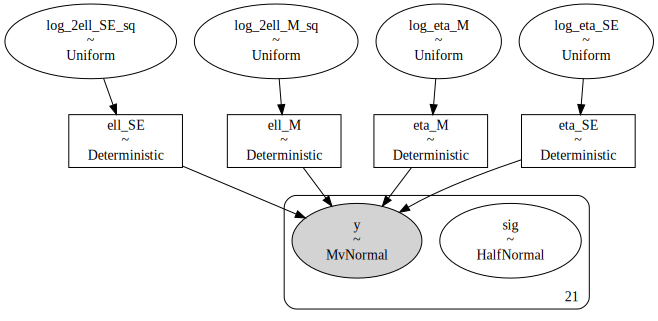

In [26]:
with pm.Model() as sem_gp_model:
    log_2ell_SE_sq = pm.Uniform("log_2ell_SE_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_SE = pm.Deterministic("ell_SE", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_SE_sq))

    log_eta_SE= pm.Uniform("log_eta_SE", lower=-15, upper=5)
    eta_SE = pm.Deterministic("eta_SE", pm.math.exp(log_eta_SE))

    log_2ell_M_sq = pm.Uniform("log_2ell_M_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_M = pm.Deterministic("ell_M", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_M_sq))

    log_eta_M= pm.Uniform("log_eta_M", lower=-15, upper=5)
    eta_M = pm.Deterministic("eta_M", pm.math.exp(log_eta_M))

    cov_func = eta_SE**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_SE) + eta_M**2 * pm.gp.cov.Matern32(input_dim=1, ls=ell_M)
    
    gp = pm.gp.Marginal(cov_func=cov_func) # zero mean function 

    sig = pm.HalfNormal("sig", sigma=y_stderr) 
    cov_noise = pm.gp.cov.WhiteNoise(sigma=y_stderr)

    y_ = gp.marginal_likelihood(
        "y", 
        X=t.reshape(-1,1), 
        y=y.reshape(-1,1).flatten(), 
        sigma=cov_noise
    ) 

pm.model_to_graphviz(sem_gp_model)

Sampling: [log_2ell_M_sq, log_2ell_SE_sq, log_eta_M, log_eta_SE, sig, y]


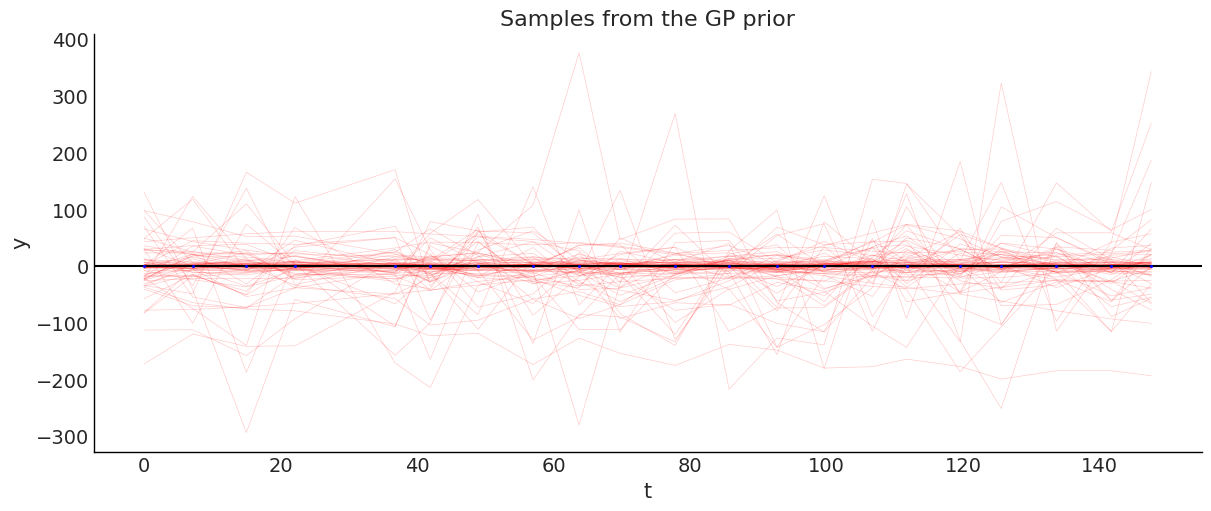

In [27]:
with sem_gp_model:
    sem_gp_trace = pm.sample_prior_predictive(samples=N_PPC, random_seed=None)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in sem_gp_trace.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=0.5, alpha=0.2, color="red")

ax.scatter(x=t, y=y, s=1.5, c="blue", zorder=10)
ax.axhline(0, color="black")
ax.set_title("Samples from the GP prior")
ax.set_ylabel("y")
ax.set_xlabel("t");

In [28]:
with sem_gp_model:
    sem_gp_trace.extend(
        pm.sample(
            draws=N_DRAWS, 
            tune=N_TUNE, 
            chains=4,
            cores=4, 
            random_seed=rng
        )       
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_eta_SE, log_2ell_M_sq, log_eta_M, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [29]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta_SE", "log_eta_M"]
az.summary(sem_gp_trace, stat_focus="median", fmt="wide", var_names=variable_names, round_to="none", kind="all")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
log_2ell_SE_sq,10.390564,0.195206,-2.433330,10.665673,0.032211,164.618611,11.521294,1.077772
log_2ell_M_sq,-2.240045,3.684615,-9.496899,10.401596,0.492940,235.873819,11.635469,1.079241
log_eta_SE,-2.077543,0.282345,-5.273991,-1.180468,0.036139,213.135985,11.540374,1.071492
log_eta_M,-5.125740,0.133879,-5.443537,-2.151106,0.021384,130.818712,11.448957,1.088301


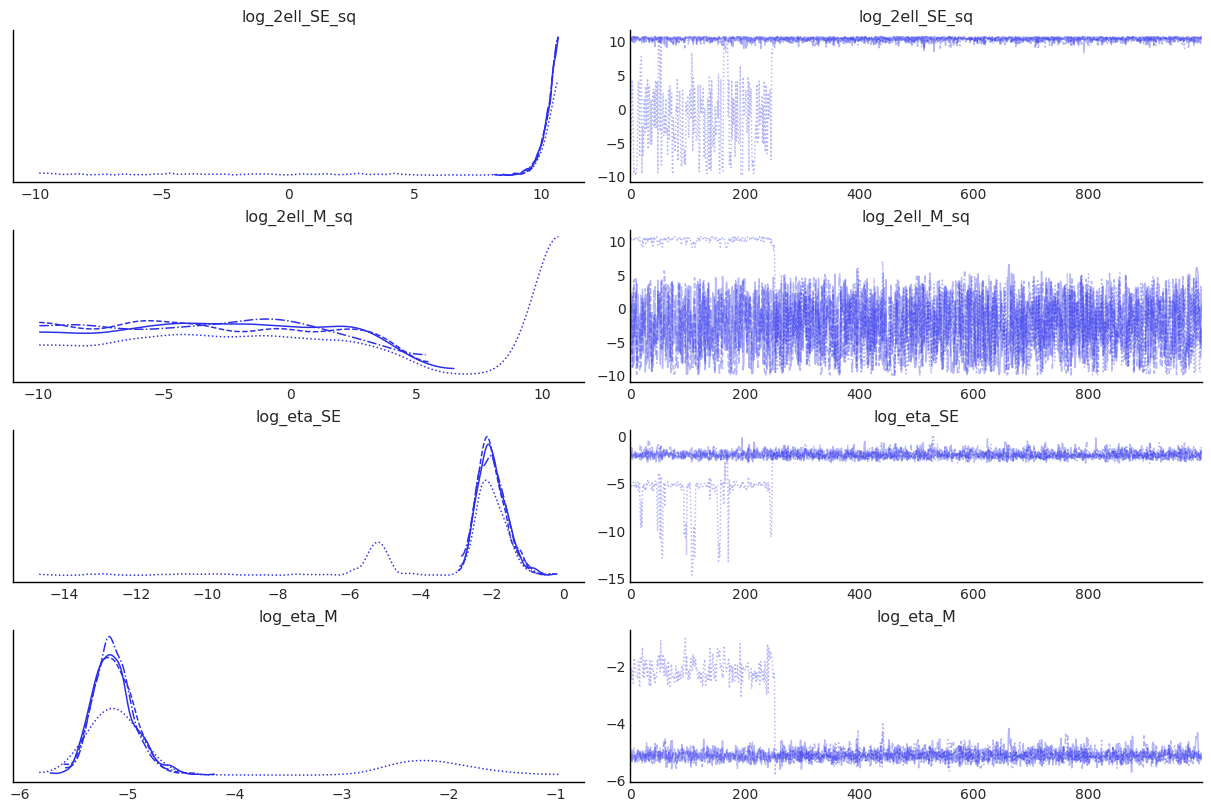

In [30]:
az.plot_trace(sem_gp_trace, var_names=variable_names, combined=False);

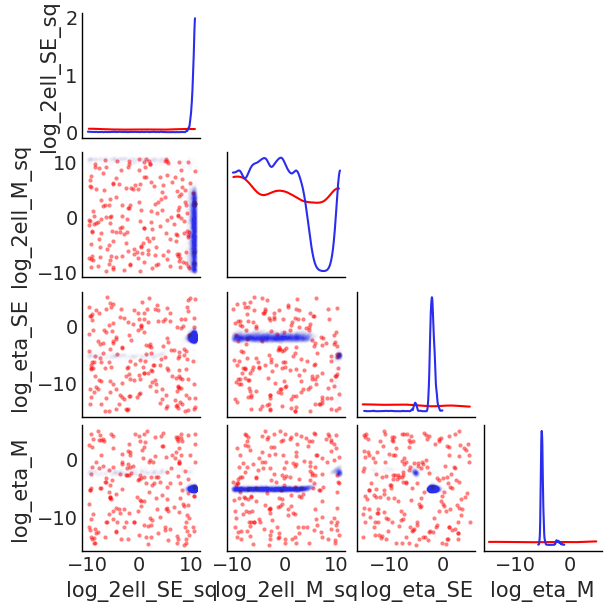

In [31]:
ax_list = az.plot_pair(
    sem_gp_trace, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(6,6), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    sem_gp_trace, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

In [32]:
t_new = np.linspace(
    start=np.floor(t.min()), 
    stop=np.ceil(t.max()), 
    num = N_NEW
).reshape(-1,1)

with sem_gp_model:
    f_star = gp.conditional(name="f_star", Xnew=t_new, jitter=1e-6, pred_noise=False) 

In [33]:
with sem_gp_model:
    sem_gp_trace.extend(
        pm.sample_posterior_predictive(
            sem_gp_trace.posterior,  
            var_names=["f_star"], 
            random_seed=None
        )
    )

Sampling: [f_star]


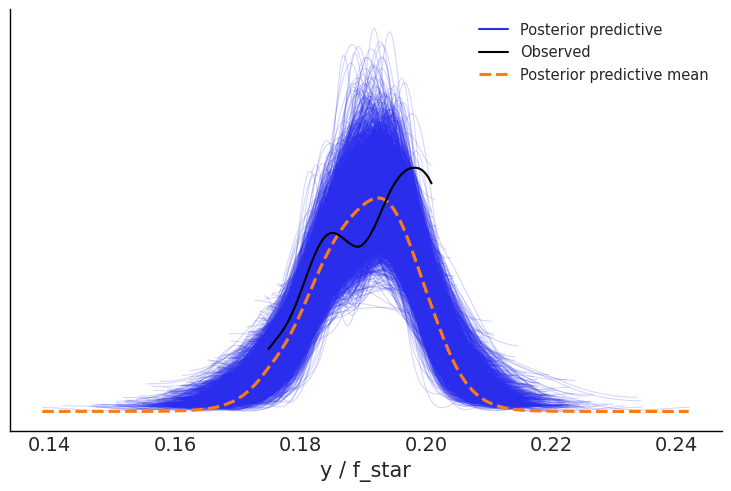

In [34]:
az.plot_ppc(sem_gp_trace, data_pairs={"y":"f_star"});

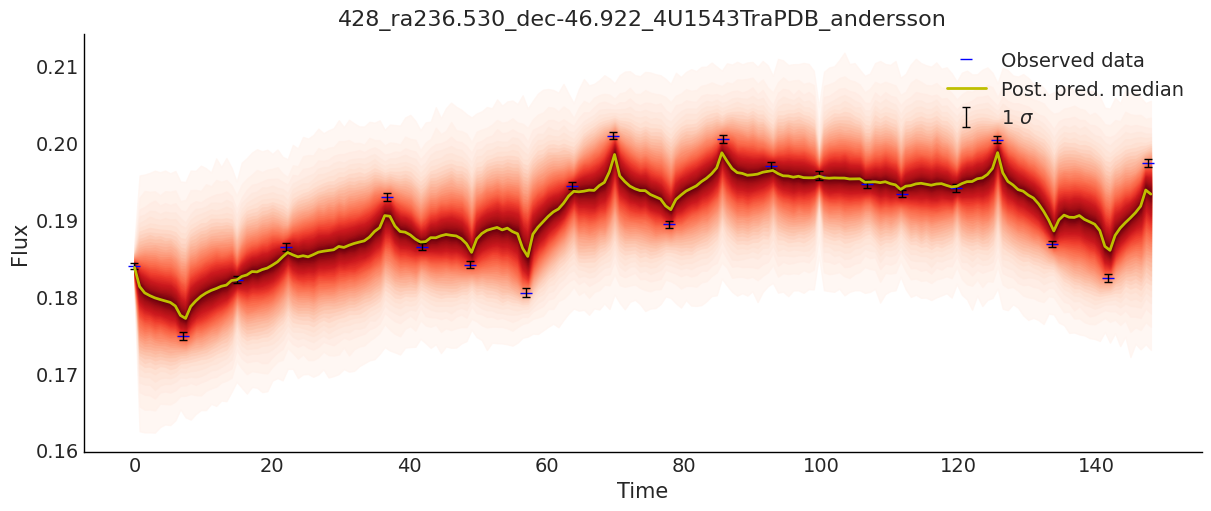

In [35]:
y_postpred = az.extract(sem_gp_trace.posterior_predictive, var_names=["f_star"])
y_postpred_median = y_postpred.median(dim="sample")

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(t, y, "_b", ms=8, alpha=1, label="Observed data")
plt.errorbar(x=t, y=y, yerr=y_stderr, fmt="none", ecolor="k", elinewidth=1, capsize=3, label=r"1 $\sigma$")
plot_gp_dist(
    ax=ax, 
    samples=y_postpred.transpose("sample", ...),
    x=t_new,
    plot_samples=False
)
plt.plot(t_new.flatten(), y_postpred_median, "y", linewidth=2, label="Post. pred. median")
plt.title(f"{fpath.stem}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend();